In [1]:
import numpy as np
import scipy as sp
import os
import sys
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
lgcg_path = os.path.abspath(os.path.join('../lazified_pdap'))
if lgcg_path not in sys.path:
    sys.path.append(lgcg_path)
from lib.measure import Measure
from lib.ssn import SSN
from lazified_pdap import LazifiedPDAP

# Heat Equation

## Generate Data and Define Functions

In [2]:
Omega = np.array([[0,1], [0,1]])
alpha = 1e-1
observation_resolution = 4
std_factor = 0.1
true_sources = np.array([[0.28, 0.71], [0.51,0.27], [0.71,0.53]])
true_weights = np.array([1,-0.7, 0.8])

In [3]:
observations = (np.array(np.meshgrid(
                    *(
                        np.linspace(bound[0], bound[1], observation_resolution+2)
                        for bound in Omega
                    ))
            ).reshape(len(Omega), -1).T)
observations = np.array([obs for obs in observations if all(obs!=0) and all(obs!=1)])

In [4]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    outer_factor = np.sqrt(std_factor*np.pi)**Omega.shape[0]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        columns.append(exponentiated)
    result = np.transpose(np.array(columns), axes=(1,0))/outer_factor # shape=(len(x), len(observations))
    return result

In [5]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [6]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [7]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    outer_factor = std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        gradient = diff * exponentiated.reshape(-1,1) # shape=(len(x),Omega.shape[0])
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2))/outer_factor # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [8]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    outer_factors = [-std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2,std_factor**2*np.sqrt(std_factor*np.pi)**Omega.shape[0]/4]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated_normed_1 = np.exp(norms)/outer_factors[0] # (len(x),)
        exponentiated_normed_2 = np.exp(norms)/outer_factors[1] # (len(x),)
        first_part = np.repeat(np.eye(Omega.shape[0])[np.newaxis,:],len(x),axis=0)*exponentiated_normed_1.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        second_part = np.einsum('ij,ik->ijk', diff, diff)*exponentiated_normed_2.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        hessians.append(first_part+second_part)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [9]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [10]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [11]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [12]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [13]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

In [14]:
a = np.arange(0,1,0.01)
if Omega.shape[0] == 1:
    vals = np.linalg.norm(kappa(a.reshape(1,-1).T), axis=1)
    norm_kappa = max(vals)
elif Omega.shape[0] == 2:
    x, y = np.meshgrid(a,a)
    points = np.array(list(zip(x.flatten(), y.flatten())))
    vals = np.linalg.norm(kappa(points), axis=1)
    norm_kappa = max(vals) # ||k([0.5,0.5])||
elif Omega.shape[0] == 3:
    x, y, z = np.meshgrid(a,a,a)
    points = np.array(list(zip(x.flatten(), y.flatten(), z.flatten())))
    vals = np.linalg.norm(kappa(points), axis=1)
    norm_kappa = max(vals)
else:
    norm_kappa = 10
norm_kappa

6.264527262470839

In [15]:
a = np.arange(0,1,0.1)
if Omega.shape[0] == 1:
    vals = np.linalg.norm(grad_kappa(a.reshape(1,-1).T), axis=(1,2))
    norm_kappa1 = max(norm_kappa, max(vals))
elif Omega.shape[0] == 2:
    B, D = np.meshgrid(a,a)
    points = np.array(list(zip(B.flatten(), D.flatten())))
    vals = np.linalg.norm(grad_kappa(points), axis=(1,2))
    norm_kappa1 = max(norm_kappa, max(vals))
elif Omega.shape[0] == 3:
    x, y, z = np.meshgrid(a,a,a)
    points = np.array(list(zip(x.flatten(), y.flatten(), z.flatten())))
    vals = np.linalg.norm(grad_kappa(points), axis=(1,2))
    norm_kappa1 = max(norm_kappa, max(vals))
else:
    norm_kappa1 = 50
norm_kappa1

27.126794337315015

In [16]:
gamma = 1
theta = 1e-1
sigma = 2e-3
m = 1e-3
bar_m = 1e-1
L = 1
L_H = max(np.abs(true_weights))
R = 1e-2
L_H

1.0

## Experiments

In [17]:
exp = LazifiedPDAP(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_kappa=norm_kappa,
           norm_kappa1=norm_kappa1,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           L_H=L_H,
           R=R
           )

In [19]:
exp.M

2.391032205368258

### PDAP

In [20]:
u, P_values, times, supports, objective_values = exp.pdap(tol=1e-14)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-14
INFO:root:1: Phi:7.375E+02, support: 1
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions and tolerance 1.000E-14: MAX ITERATIONS REACHED
INFO:root:2: Phi:1.732E+02, support: 2
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions and tolerance 1.000E-14: MAX ITERATIONS REACHED
INFO:root:3: Phi:9.305E+01, support: 3
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions and tolerance 1.000E-14: MAX ITERATIONS REACHED
INFO:root:4: Phi:6.027E+00, support: 4
INFO:root:==============================================
DEBUG:root:SSN in 5 dimensions converged in 3 iterations to tolerance 1.000E-14
INFO:root:5: Phi:2.407E+00, support: 5
INFO:root:==============================================
DEBUG:root:SSN in 6 dimensions converged in 2 iterations to tolerance 1.000E-14
INFO:root:6: Phi:3.931E-01, support: 6
INFO

In [21]:
best = objective_values[-1]

In [22]:
np.array(times[:127])

array([2.38418579e-07, 4.18431044e-01, 1.04219627e+00, 1.63789558e+00,
       2.19843435e+00, 2.71504903e+00, 3.20965147e+00, 3.77218604e+00,
       4.25794053e+00, 4.72859573e+00, 5.18463206e+00, 5.63479400e+00,
       6.11822319e+00, 6.62584686e+00, 7.09952021e+00, 7.59171414e+00,
       8.05779266e+00, 8.52308035e+00, 8.99023223e+00, 9.47606373e+00,
       9.98122334e+00, 1.04586179e+01, 1.09188306e+01, 1.13593760e+01,
       1.18496115e+01, 1.23145330e+01, 1.27793734e+01, 1.32756631e+01,
       1.37670116e+01, 1.42132204e+01, 1.47056115e+01, 1.51985340e+01,
       1.57450454e+01, 1.62031600e+01, 1.67054157e+01, 1.71655104e+01,
       1.76761296e+01, 1.81986217e+01, 1.86635735e+01, 1.92270210e+01,
       1.97201936e+01, 2.01633193e+01, 2.06141446e+01, 2.10860300e+01,
       2.15470774e+01, 2.20299225e+01, 2.24876997e+01, 2.29483402e+01,
       2.34765096e+01, 2.39271548e+01, 2.43913689e+01, 2.48511713e+01,
       2.52912235e+01, 2.57479277e+01, 2.61932025e+01, 2.66848056e+01,
      

In [23]:
np.array(supports[:127])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 7, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9,
       8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 8, 8, 8, 8, 7])

In [24]:
objective_values[:127]-best

array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903637e+00,
       2.29592885e-01, 1.29111897e-01, 6.02585416e-02, 5.81289511e-02,
       5.43698664e-02, 4.28609944e-02, 2.43456507e-02, 2.24655449e-02,
       2.19692476e-02, 1.97512429e-02, 1.45352924e-02, 1.17524225e-02,
       8.37236242e-03, 8.03803951e-03, 7.27480820e-03, 5.49766958e-03,
       4.74499614e-03, 4.33283646e-03, 3.06984433e-03, 3.03428454e-03,
       2.57014224e-03, 2.25412115e-03, 2.23311030e-03, 1.77761494e-03,
       1.74648370e-03, 1.02712726e-03, 1.00858173e-03, 7.05155795e-04,
       4.57693553e-04, 3.73211215e-04, 3.33190434e-04, 3.26993069e-04,
       3.19892763e-04, 2.76245761e-04, 2.23204779e-04, 2.02454957e-04,
       1.54179009e-04, 1.15907286e-04, 8.63980535e-05, 6.07049270e-05,
       5.67240418e-05, 4.57625429e-05, 4.45959475e-05, 4.10285053e-05,
       3.04741290e-05, 1.81638719e-05, 1.30621429e-05, 1.09294757e-05,
       1.01612381e-05, 9.32043324e-06, 8.04411016e-06, 5.27245165e-06,
      

In [25]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.2832272  0.71433139]
 [0.28322726 0.71433129]
 [0.28322729 0.71433135]
 [0.28322745 0.71433136]
 [0.49565836 0.23548626]
 [0.49565837 0.23548618]
 [0.49565841 0.23548619]
 [0.7305882  0.54790141]
 [0.73058828 0.54790142]
 [0.73058832 0.54790134]
 [0.73058842 0.54790129]] and coefficients [ 0.06428593  0.50386777  0.42333066  0.00420707 -0.23968759 -0.37173543
 -0.00615768  0.11494182  0.04807306  0.30986734  0.23925005]
[4.17721413e-15]
-6.938893903907228e-16


### Newton

In [57]:
u, times, supports, inner_loop, lgcg_lazy, lgcg_total, objective_values, dropped_tot, epsilons = exp.newton(tol=1e-12, damped=False, drop_frequency=5)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-03
INFO:root:1: choice: 0, lazy: True, support: 0, epsilon: 0.05000000000000001, objective: 2.590E+01, dropped: False
INFO:root:1, 1: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.136E+00
INFO:root:1, 2: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.129E+00
INFO:root:1, 3: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.129E+00
INFO:root:1, 4: lazy: True, support: 1, epsilon: 0.05000000000000001, objective: 5.129E+00
INFO:root:False
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root:2: choice: 4, lazy: True, support: 2, epsilon: 0.05000000000000001, objective: 4.579E+00, dropped: False
INFO:root:2, 1: lazy: N/A, support: 2, epsilon: 0.05000000000000001, objective: 2.779E+00
INFO:root:2, 2: lazy: N/A, support: 2, epsilon: 0.05000000000000001, objective: 2.690E+00
INFO:root:2, 3: lazy: N/A, support: 2, epsilon: 0.050

In [27]:
dropped_tot

0

In [28]:
np.array(times)

array([2.38418579e-07, 8.58068466e-03, 1.58250332e-02, 2.24006176e-02,
       2.71444321e-02, 3.42092514e-02, 4.48961258e-02, 5.06410599e-02,
       5.55870533e-02, 6.00469112e-02, 6.50849342e-02, 7.37345219e-02,
       8.36610794e-02, 9.10894871e-02, 1.03396893e-01, 1.12055540e-01,
       1.22375011e-01, 1.31371498e-01, 1.35909319e-01, 1.42207384e-01,
       1.48448229e-01, 1.52497768e-01, 6.64011955e-01, 6.69476032e-01,
       1.13512897e+00, 1.14139056e+00, 1.15211535e+00, 1.15993071e+00,
       1.17336154e+00, 1.17960572e+00, 1.19218516e+00, 1.19767928e+00,
       1.20940447e+00, 1.21699309e+00, 1.22190523e+00, 1.22762203e+00,
       1.23251295e+00, 1.23861456e+00, 1.24325633e+00, 1.74201059e+00,
       1.75251889e+00, 1.75891829e+00, 1.76313019e+00, 2.23953962e+00])

In [29]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3])

In [58]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
if inner_loop[-1]:
    end = len(inner_loop)-0.5
    intervals.append((start,end))
np.array(intervals)

array([[ 1.5,  5.5],
       [ 6.5, 11.5],
       [12.5, 13.5],
       [14.5, 15.5],
       [16.5, 21.5],
       [22.5, 23.5],
       [24.5, 25.5],
       [26.5, 27.5],
       [28.5, 29.5],
       [30.5, 31.5],
       [32.5, 38.5],
       [39.5, 43.5]])

In [31]:
objective_values-best

array([ 2.56626430e+01,  2.56626430e+01,  4.89708109e+00,  4.89011091e+00,
        4.89010890e+00,  4.89010890e+00,  4.34012696e+00,  2.54033247e+00,
        2.45081702e+00,  2.45038785e+00,  2.45038403e+00,  2.45038403e+00,
        2.44180213e+00,  5.59400919e+01,  1.36858216e+00,  7.09831576e+00,
        2.31728190e-01,  2.57559619e-02,  7.34944225e-03,  5.19115390e-03,
        2.17921964e-03,  1.12603642e-02,  2.17921964e-03,  5.11451882e-03,
        2.13883343e-03,  4.77720606e-02,  1.92880717e-03,  1.01096838e-02,
        1.83115153e-03,  5.76279967e-03,  1.36887058e-03,  3.60108190e-03,
        1.00675861e-03,  6.40490808e-04,  3.87994516e-05,  5.21726647e-06,
        2.81463712e-06,  6.20980579e-07,  9.66281955e-07,  6.20980579e-07,
        9.36530484e-09, -5.05151476e-15, -5.24580379e-15, -5.24580379e-15])

In [32]:
np.array(epsilons)

array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 4.64273548e-03, 4.64273548e-03,
       9.81676584e-04, 9.81676584e-04, 9.81676584e-04, 9.81676584e-04,
       9.81676584e-04, 9.81676584e-04, 9.81676584e-04, 9.81676584e-04,
       9.81676584e-04, 9.81676584e-04, 9.81676584e-04, 9.81676584e-04,
       9.81676584e-04, 9.81676584e-04, 9.81676584e-04, 7.26404214e-05,
       1.02930954e-04, 1.02930954e-04, 1.02930954e-04, 2.57507434e-15])

In [33]:
print(lgcg_lazy)
print(lgcg_total)

11
15


In [34]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
[5.30131494e-15]
-5.273559366969494e-16


In [35]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([402.39077637, 272.29702435, 194.35314107,  68.45550406,
        48.27005106,   1.82700374,   7.42624617,  18.87504406,
        24.25981579])

### Newton Damped

In [59]:
u, times, supports, inner_loop, lgcg_lazy, lgcg_total, objective_values, dropped_tot, epsilons = exp.newton(tol=1e-12, damped=True, damping_root=1)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-03
INFO:root:1: choice: 0, lazy: True, support: 0, epsilon: 0.05000000000000001, objective: 2.590E+01, dropped: False
INFO:root:1, 1: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.820E+00
INFO:root:1, 2: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.727E+00
INFO:root:1, 3: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.644E+00
INFO:root:1, 4: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.570E+00
INFO:root:1, 5: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.505E+00
INFO:root:1, 6: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.447E+00
INFO:root:1, 7: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.396E+00
INFO:root:1, 8: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.351E+00
INFO:root:1, 9: lazy: N/A, support: 1, epsilon: 0.05000000000000001, objective: 5.312

In [39]:
dropped_tot

0

In [40]:
np.array(times)

array([2.38418579e-07, 1.18465424e-02, 1.88066959e-02, 3.02670002e-02,
       3.56731415e-02, 4.15892601e-02, 4.72061634e-02, 5.34479618e-02,
       5.88636398e-02, 6.60176277e-02, 7.19494820e-02, 7.80100822e-02,
       8.42995644e-02, 9.02578831e-02, 9.55674648e-02, 1.00833416e-01,
       1.06026888e-01, 1.11744165e-01, 1.17453814e-01, 1.22920036e-01,
       1.29497290e-01, 1.34731770e-01, 1.39455080e-01, 1.44275904e-01,
       1.49066925e-01, 1.53709173e-01, 1.60214901e-01, 1.65451527e-01,
       1.70458794e-01, 1.74128771e-01, 1.78067923e-01, 1.85987234e-01,
       1.94742441e-01, 2.02468872e-01, 2.07917213e-01, 2.13300467e-01,
       2.19124079e-01, 2.24780560e-01, 2.29963303e-01, 2.35563278e-01,
       2.41349936e-01, 2.46809959e-01, 2.52551556e-01, 2.58374214e-01,
       2.63869286e-01, 2.69862652e-01, 2.75438786e-01, 2.80704975e-01,
       2.86530972e-01, 2.92293787e-01, 2.97790527e-01, 3.03611517e-01,
       3.09106588e-01, 3.14450979e-01, 3.20564985e-01, 3.25967073e-01,
      

In [41]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       3, 3])

In [60]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
if inner_loop[-1]:
    end = len(inner_loop)-0.5
    intervals.append((start,end))
np.array(intervals)

array([[  1.5,  31.5],
       [ 32.5,  58.5],
       [ 59.5,  60.5],
       [ 61.5,  62.5],
       [ 63.5, 108.5],
       [109.5, 111.5]])

In [43]:
objective_values-best

array([ 2.56626430e+01,  2.56626430e+01,  5.58059645e+00,  5.48796890e+00,
        5.40512051e+00,  5.33124615e+00,  5.26561178e+00,  5.20754251e+00,
        5.15641318e+00,  5.11164078e+00,  5.07267844e+00,  5.03901064e+00,
        5.01014947e+00,  4.98563174e+00,  4.96501690e+00,  4.94788559e+00,
        4.93383879e+00,  4.92249752e+00,  4.91350301e+00,  4.90651728e+00,
        4.90122407e+00,  4.89733011e+00,  4.89456651e+00,  4.89269039e+00,
        4.89148647e+00,  4.89076860e+00,  4.89038100e+00,  4.89019920e+00,
        4.89013023e+00,  4.89011170e+00,  4.89010902e+00,  4.89010890e+00,
        4.33999529e+00,  2.98914704e+00,  2.88612695e+00,  2.80175517e+00,
        2.73238891e+00,  2.67530300e+00,  2.62838259e+00,  2.58993972e+00,
        2.55859749e+00,  2.53321361e+00,  2.51282810e+00,  2.49662636e+00,
        2.48391236e+00,  2.47408865e+00,  2.46664089e+00,  2.46112563e+00,
        2.45716031e+00,  2.45441508e+00,  2.45260605e+00,  2.45149023e+00,
        2.45086213e+00,  

In [44]:
np.array(epsilons)

array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
      

In [45]:
print(lgcg_lazy)
print(lgcg_total)

7
11


In [46]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
[1.99840144e-15]
1.970645868709653e-15


### LPDAP

In [55]:
u, Phi_ks, times, supports, objective_values, dropped_tot, epsilons = exp.lpdap(tol=1e-12)

INFO:root:1: Step: GCG, Lazy True, Phi_k: 9.886E+03, epsilon: 5.000E-02, support: 0, dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-03
INFO:root:2: Step: GCG, Lazy True, Phi_k: 7.648E+02, epsilon: 5.000E-02, support: 1, dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 3 iterations to tolerance 1.000E-03
INFO:root:3: Step: GCG, Lazy True, Phi_k: 1.645E+02, epsilon: 5.000E-02, support: 2, dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 1.000E-03
INFO:root:4: Step: GCG, Lazy True, Phi_k: 1.010E+02, epsilon: 5.000E-02, support: 3, dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 2 iterations to tolerance 1.000E-03
INFO:root:5: Step: GCG, Lazy True, Phi_k: 6.220E+00, eps

In [48]:
dropped_tot

0

In [49]:
np.array(times)

array([5.00822067e-03, 2.39226818e-02, 4.39913273e-02, 6.43539429e-02,
       8.49573612e-02, 1.05225801e-01, 1.25687599e-01, 1.46164179e-01,
       1.67770863e-01, 7.11780071e-01, 7.29965210e-01, 7.47247934e-01,
       7.63816118e-01, 1.34156585e+00, 1.36275458e+00, 1.86567879e+00,
       1.88338733e+00, 1.89911151e+00, 1.91899037e+00, 1.93670297e+00,
       1.96150661e+00, 2.50524879e+00, 2.52784061e+00, 2.54926038e+00,
       3.09177184e+00, 3.11411738e+00, 3.13033271e+00, 3.14962196e+00,
       3.17570353e+00, 3.19966984e+00, 3.73969698e+00, 3.75688314e+00,
       4.22693658e+00, 4.23949671e+00, 4.25286674e+00, 4.26836300e+00,
       4.73042464e+00, 5.20169139e+00, 5.66969848e+00, 5.68024445e+00,
       5.69259548e+00, 5.70796347e+00, 5.72350836e+00, 5.73322773e+00,
       6.29122472e+00, 6.30082655e+00, 6.31362367e+00, 6.32242966e+00,
       6.33538008e+00, 6.34752488e+00, 6.96176457e+00, 7.41738558e+00,
       7.42729044e+00, 7.44009399e+00, 7.45232677e+00, 7.46431088e+00,
      

In [50]:
np.array(supports)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  7,  7,  8,  9,  8,  8,  8,  9,
       10,  9, 10,  9,  9,  8,  8,  8,  8,  8,  9, 10,  9,  9,  9, 10, 10,
       10, 11, 10, 10,  9,  9,  9,  8,  9,  8,  8,  9, 10,  9,  9, 10, 10,
        8,  8,  8,  9, 10, 11,  9,  9,  8,  8, 10, 13, 10,  9,  9,  8,  8,
        8,  9, 10,  9,  9, 10,  8,  7,  8, 11,  9, 10, 13, 10, 10,  9,  9,
        9,  8,  9, 11, 12, 11, 13, 12, 12, 10, 10,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  8,  8,  8,  8,  7,  8,  9,  8,  8, 10,  9,  8, 11,
        9, 10, 10, 11])

In [51]:
objective_values-best

array([2.56626430e+01, 5.68389440e+00, 2.59001760e+00, 1.71526034e+00,
       2.30637908e-01, 1.22566759e-01, 5.96825854e-02, 5.71032551e-02,
       5.37492393e-02, 4.16045844e-02, 2.03598543e-02, 1.93706673e-02,
       1.85833768e-02, 1.51984354e-02, 1.22395359e-02, 1.01108092e-02,
       9.19103903e-03, 9.16965325e-03, 6.74362031e-03, 6.63321629e-03,
       5.00712147e-03, 4.13478500e-03, 3.11887174e-03, 3.05519531e-03,
       2.01701788e-03, 1.96338604e-03, 1.84629753e-03, 1.49748578e-03,
       1.19904005e-03, 6.15231665e-04, 5.70760185e-04, 5.04951682e-04,
       3.75158897e-04, 3.57330714e-04, 3.44118864e-04, 2.95353764e-04,
       2.24275075e-04, 2.18184857e-04, 2.05529104e-04, 1.80134908e-04,
       1.29515398e-04, 1.10066811e-04, 9.88904508e-05, 9.38867774e-05,
       6.91313238e-05, 6.68964442e-05, 5.02626439e-05, 4.79708632e-05,
       4.02687627e-05, 3.60214271e-05, 2.33490400e-05, 2.21194804e-05,
       2.02424190e-05, 1.41829263e-05, 1.17037805e-05, 1.13294217e-05,
      

In [52]:
np.array(epsilons)

array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 2.28377115e-02, 2.28377115e-02,
       2.28377115e-02, 2.28377115e-02, 1.10924920e-02, 1.10924920e-02,
       4.75484299e-03, 4.75484299e-03, 4.75484299e-03, 4.75484299e-03,
       4.75484299e-03, 4.75484299e-03, 1.64712213e-03, 1.64712213e-03,
       1.64712213e-03, 6.80226804e-04, 6.80226804e-04, 6.80226804e-04,
       6.80226804e-04, 6.80226804e-04, 6.80226804e-04, 3.16173107e-04,
       3.16173107e-04, 1.48083647e-04, 1.48083647e-04, 1.48083647e-04,
       1.48083647e-04, 1.48083647e-04, 1.48083647e-04, 6.50099286e-05,
       6.50099286e-05, 6.50099286e-05, 6.50099286e-05, 6.50099286e-05,
       6.50099286e-05, 2.24632003e-05, 2.24632003e-05, 2.24632003e-05,
       2.24632003e-05, 2.24632003e-05, 2.24632003e-05, 2.24632003e-05,
       8.42377825e-06, 8.42377825e-06, 8.42377825e-06, 8.42377825e-06,
      

In [56]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.283226   0.71433135]
 [0.28322702 0.71433109]
 [0.28322703 0.71433195]
 [0.28322805 0.71433148]
 [0.28322886 0.71433089]
 [0.49565798 0.23548655]
 [0.49565846 0.23548594]
 [0.4956585  0.23548642]
 [0.495659   0.23548602]
 [0.73058755 0.5479017 ]
 [0.73058936 0.54790092]] and coefficients [ 0.15889505  0.38419598  0.08858788  0.32357095  0.04044155 -0.18376399
 -0.35190137 -0.04738175 -0.03453353  0.3992167   0.3129155 ]
[4.43783899e-13]
-1.7910672944765338e-13


## Plots

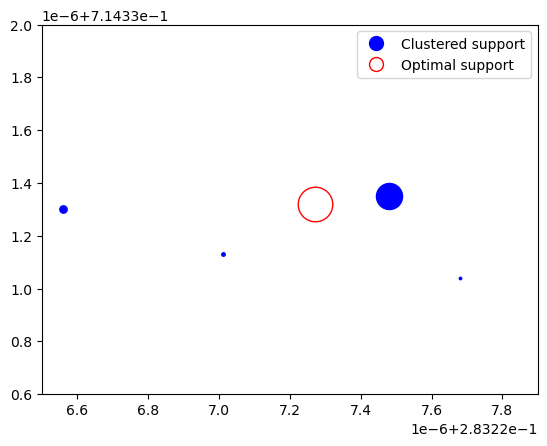

In [73]:
clustered_points = [[0.28322656, 0.7143313 ], [0.28322701, 0.71433113], [0.28322748, 0.71433135], [0.28322768, 0.71433104]]
clustered_weights = [0.21149885,  0.1,  0.75096038, 0.07]
true_point = [0.28322727, 0.71433132]
true_weight = 0.99569143
plt.plot(0,0,"o", c="b", markersize=10,label="Clustered support"); # Point for legend
plt.plot(0,0,"o", c="r", fillstyle="none", markersize=10,label="Optimal support"); # Point for legend
for (x,c) in zip(clustered_points, clustered_weights):
    plt.plot(x[0], x[1], "o", c="b", markersize=25*c);
plt.plot(true_point[0], true_point[1], "o", fillstyle="none", c="r", markersize=25*true_weight);
plt.ylim(7.143313e-1-7e-7, 7.143313e-1+7e-7)
plt.xlim(2.832272e-1-7e-7, 2.832272e-1+7e-7)
plt.legend(fontsize=10);

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f14ac5309d0>


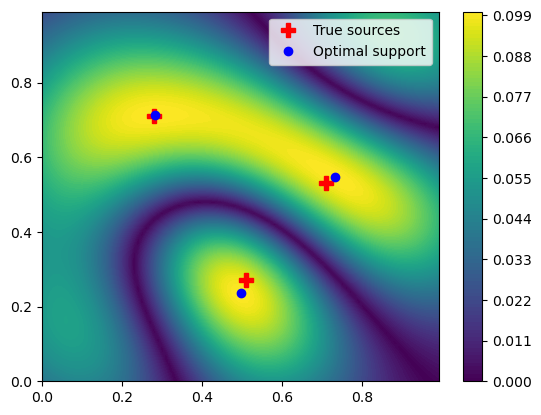

In [108]:
u_tilde = u #Measure(support=[[0.16189578,0.67106819],[0.22222222,0.77777778],[0.33333333,0.66666667],[0.33333333,0.77777778],[0.44444444,0.22222222],[0.44444444,0.33333333],[0.5129322,0.21945235],[0.66666667,0.55555556],[0.77777778,0.44444444],[0.77777778,0.55555556],[0.88888889,0.88888889]], coefficients=[0.12089905,0.30391103,0.5035049,0.13645795,-0.11020099,-0.09355168,-0.43700644,0.23772164,0.05493194,0.41683878,-0.00129572])
P = lambda x: np.abs(p(u_tilde)(x))
a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
vals = np.array([P(np.array([x_1,x_2])) for x_1, x_2 in zip(B.flatten(), D.flatten())]).reshape((100,100))

plt.contourf(B, D, vals, levels=100);
plt.colorbar();
for i, x in enumerate(true_sources):
    if i:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10);
    else:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10, label="True sources");
for i, x in enumerate(u_tilde.support):
    if i:
        plt.plot([x[0]], [x[1]], "o", c="b");
    else:
        plt.plot([x[0]], [x[1]], "o", c="b", label="Optimal support");
plt.legend();

In [ ]:
residuals_pdap = np.array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903637e+00,
       2.29592885e-01, 1.29111897e-01, 6.02585416e-02, 5.81289511e-02,
       5.43698664e-02, 4.28609944e-02, 2.43456507e-02, 2.24655449e-02,
       2.19692476e-02, 1.97512429e-02, 1.45352924e-02, 1.17524225e-02,
       8.37236242e-03, 8.03803951e-03, 7.27480820e-03, 5.49766958e-03,
       4.74499614e-03, 4.33283646e-03, 3.06984433e-03, 3.03428454e-03,
       2.57014224e-03, 2.25412115e-03, 2.23311030e-03, 1.77761494e-03,
       1.74648370e-03, 1.02712726e-03, 1.00858173e-03, 7.05155795e-04,
       4.57693553e-04, 3.73211215e-04, 3.33190434e-04, 3.26993069e-04,
       3.19892763e-04, 2.76245761e-04, 2.23204779e-04, 2.02454957e-04,
       1.54179009e-04, 1.15907286e-04, 8.63980535e-05, 6.07049270e-05,
       5.67240418e-05, 4.57625429e-05, 4.45959475e-05, 4.10285053e-05,
       3.04741290e-05, 1.81638719e-05, 1.30621429e-05, 1.09294757e-05,
       1.01612381e-05, 9.32043324e-06, 8.04411016e-06, 5.27245165e-06,
       4.24349354e-06, 3.14384592e-06, 2.27093697e-06, 2.09990078e-06,
       1.54914535e-06, 1.32281388e-06, 1.21839882e-06, 7.01230133e-07,
       5.11944746e-07, 4.95775988e-07, 2.81897793e-07, 2.65692097e-07,
       2.43794268e-07, 2.04783395e-07, 1.51913784e-07, 1.42793265e-07,
       1.19938613e-07, 1.02398590e-07, 8.53726974e-08, 6.44645053e-08,
       4.03827174e-08, 2.99799419e-08, 2.78975285e-08, 2.69322259e-08,
       1.81523095e-08, 1.70902468e-08, 1.22499430e-08, 1.18562841e-08,
       1.04506356e-08, 9.08264025e-09, 4.52308146e-09, 3.98831332e-09,
       2.17250190e-09, 1.77452125e-09, 1.67539874e-09, 1.45759801e-09,
       1.33035957e-09, 6.07527556e-10, 5.27208888e-10, 5.16899079e-10,
       4.39092374e-10, 4.29219077e-10, 2.96123653e-10, 2.32978747e-10,
       2.23143504e-10, 1.82267534e-10, 1.35761957e-10, 1.09979997e-10,
       1.05151166e-10, 6.88229196e-11, 4.99675856e-11, 4.72722694e-11,
       2.55638011e-11, 2.36259623e-11, 2.24313901e-11, 1.96570815e-11,
       1.70958525e-11, 8.63545346e-12, 7.26635419e-12, 4.30627756e-12,
       4.00612876e-12, 3.83121312e-12, 2.72357137e-12, 2.26507701e-12,
       1.90547578e-12, 1.68731695e-12, 1.61057279e-12, 1.28191902e-12,
       9.30394650e-13, 8.47377724e-13, 4.85556040e-13])

times_pdap = np.array([2.38418579e-07, 4.18431044e-01, 1.04219627e+00, 1.63789558e+00,
       2.19843435e+00, 2.71504903e+00, 3.20965147e+00, 3.77218604e+00,
       4.25794053e+00, 4.72859573e+00, 5.18463206e+00, 5.63479400e+00,
       6.11822319e+00, 6.62584686e+00, 7.09952021e+00, 7.59171414e+00,
       8.05779266e+00, 8.52308035e+00, 8.99023223e+00, 9.47606373e+00,
       9.98122334e+00, 1.04586179e+01, 1.09188306e+01, 1.13593760e+01,
       1.18496115e+01, 1.23145330e+01, 1.27793734e+01, 1.32756631e+01,
       1.37670116e+01, 1.42132204e+01, 1.47056115e+01, 1.51985340e+01,
       1.57450454e+01, 1.62031600e+01, 1.67054157e+01, 1.71655104e+01,
       1.76761296e+01, 1.81986217e+01, 1.86635735e+01, 1.92270210e+01,
       1.97201936e+01, 2.01633193e+01, 2.06141446e+01, 2.10860300e+01,
       2.15470774e+01, 2.20299225e+01, 2.24876997e+01, 2.29483402e+01,
       2.34765096e+01, 2.39271548e+01, 2.43913689e+01, 2.48511713e+01,
       2.52912235e+01, 2.57479277e+01, 2.61932025e+01, 2.66848056e+01,
       2.71941602e+01, 2.76745391e+01, 2.82228057e+01, 2.87059350e+01,
       2.91986158e+01, 2.96591918e+01, 3.01245105e+01, 3.06612763e+01,
       3.11264818e+01, 3.15742009e+01, 3.20552256e+01, 3.25727258e+01,
       3.30436082e+01, 3.34891362e+01, 3.39387319e+01, 3.43806977e+01,
       3.48384211e+01, 3.53679311e+01, 3.58364646e+01, 3.63660131e+01,
       3.68172412e+01, 3.72748618e+01, 3.77602508e+01, 3.82287908e+01,
       3.87673748e+01, 3.92241173e+01, 3.96939936e+01, 4.02017732e+01,
       4.06699452e+01, 4.11259463e+01, 4.15875406e+01, 4.20581708e+01,
       4.25271938e+01, 4.30223765e+01, 4.34758615e+01, 4.39644716e+01,
       4.44375000e+01, 4.49778056e+01, 4.54508140e+01, 4.59164860e+01,
       4.63767626e+01, 4.68498464e+01, 4.73146791e+01, 4.77882526e+01,
       4.82314572e+01, 4.86883800e+01, 4.91409876e+01, 4.96034687e+01,
       5.00742497e+01, 5.05222995e+01, 5.09917245e+01, 5.14420888e+01,
       5.18991868e+01, 5.23540108e+01, 5.28138382e+01, 5.32611294e+01,
       5.37129498e+01, 5.41585860e+01, 5.46534677e+01, 5.51136198e+01,
       5.56726067e+01, 5.61907368e+01, 5.66572742e+01, 5.71236105e+01,
       5.75943654e+01, 5.80605803e+01, 5.85439079e+01, 5.90268407e+01,
       5.94835589e+01, 5.99427421e+01, 6.04392116e+01])

supports_pdap = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 7, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9,
       8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 8, 8, 8, 8, 7])

residuals_newton = np.array([ 2.56626430e+01,  2.56626430e+01,  4.89708109e+00,  4.89011091e+00,
        4.89010890e+00,  4.89010890e+00,  4.34012696e+00,  2.54033247e+00,
        2.45081702e+00,  2.45038785e+00,  2.45038403e+00,  2.45038403e+00,
        2.44180213e+00,  5.59400919e+01,  1.36858216e+00,  7.09831576e+00,
        2.31728190e-01,  2.57559619e-02,  7.34944225e-03,  5.19115390e-03,
        2.17921964e-03,  1.12603642e-02,  2.17921964e-03,  5.11451882e-03,
        2.13883343e-03,  4.77720606e-02,  1.92880717e-03,  1.01096838e-02,
        1.83115153e-03,  5.76279967e-03,  1.36887058e-03,  3.60108190e-03,
        1.00675861e-03,  6.40490808e-04,  3.87994516e-05,  5.21726647e-06,
        2.81463712e-06,  6.20980579e-07,  9.66281955e-07,  6.20980579e-07,
        9.36530484e-09, -5.05151476e-15, -5.24580379e-15, -5.24580379e-15])

times_newton = np.array([2.38418579e-07, 8.58068466e-03, 1.58250332e-02, 2.24006176e-02,
       2.71444321e-02, 3.42092514e-02, 4.48961258e-02, 5.06410599e-02,
       5.55870533e-02, 6.00469112e-02, 6.50849342e-02, 7.37345219e-02,
       8.36610794e-02, 9.10894871e-02, 1.03396893e-01, 1.12055540e-01,
       1.22375011e-01, 1.31371498e-01, 1.35909319e-01, 1.42207384e-01,
       1.48448229e-01, 1.52497768e-01, 6.64011955e-01, 6.69476032e-01,
       1.13512897e+00, 1.14139056e+00, 1.15211535e+00, 1.15993071e+00,
       1.17336154e+00, 1.17960572e+00, 1.19218516e+00, 1.19767928e+00,
       1.20940447e+00, 1.21699309e+00, 1.22190523e+00, 1.22762203e+00,
       1.23251295e+00, 1.23861456e+00, 1.24325633e+00, 1.74201059e+00,
       1.75251889e+00, 1.75891829e+00, 1.76313019e+00, 2.23953962e+00])

supports_newton = np.array([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3])

intervals_newton = np.array([[ 1.5,  5.5],
       [ 6.5, 11.5],
       [12.5, 13.5],
       [14.5, 15.5],
       [16.5, 21.5],
       [22.5, 23.5],
       [24.5, 25.5],
       [26.5, 27.5],
       [28.5, 29.5],
       [30.5, 31.5],
       [32.5, 38.5],
       [39.5, 43.5]])

epsilons_newton = np.array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 4.64273548e-03, 4.64273548e-03,
       9.81676584e-04, 9.81676584e-04, 9.81676584e-04, 9.81676584e-04,
       9.81676584e-04, 9.81676584e-04, 9.81676584e-04, 9.81676584e-04,
       9.81676584e-04, 9.81676584e-04, 9.81676584e-04, 9.81676584e-04,
       9.81676584e-04, 9.81676584e-04, 9.81676584e-04, 7.26404214e-05,
       1.02930954e-04, 1.02930954e-04, 1.02930954e-04, 2.57507434e-15])

residuals_newton_damped = np.array([ 2.56626430e+01,  2.56626430e+01,  5.58059645e+00,  5.48796890e+00,
        5.40512051e+00,  5.33124615e+00,  5.26561178e+00,  5.20754251e+00,
        5.15641318e+00,  5.11164078e+00,  5.07267844e+00,  5.03901064e+00,
        5.01014947e+00,  4.98563174e+00,  4.96501690e+00,  4.94788559e+00,
        4.93383879e+00,  4.92249752e+00,  4.91350301e+00,  4.90651728e+00,
        4.90122407e+00,  4.89733011e+00,  4.89456651e+00,  4.89269039e+00,
        4.89148647e+00,  4.89076860e+00,  4.89038100e+00,  4.89019920e+00,
        4.89013023e+00,  4.89011170e+00,  4.89010902e+00,  4.89010890e+00,
        4.33999529e+00,  2.98914704e+00,  2.88612695e+00,  2.80175517e+00,
        2.73238891e+00,  2.67530300e+00,  2.62838259e+00,  2.58993972e+00,
        2.55859749e+00,  2.53321361e+00,  2.51282810e+00,  2.49662636e+00,
        2.48391236e+00,  2.47408865e+00,  2.46664089e+00,  2.46112563e+00,
        2.45716031e+00,  2.45441508e+00,  2.45260605e+00,  2.45149023e+00,
        2.45086213e+00,  2.45055216e+00,  2.45042690e+00,  2.45039033e+00,
        2.45038435e+00,  2.45038403e+00,  2.45038403e+00,  2.44180252e+00,
        1.92187709e+00,  1.36856873e+00,  2.58826851e-01,  2.31723685e-01,
        8.44523956e-02,  6.43198817e-02,  4.76605998e-02,  3.41778920e-02,
        2.36067793e-02,  1.56335457e-02,  9.88558465e-03,  5.96687498e-03,
        3.50802494e-03,  2.17664391e-03,  1.50398039e-03,  1.26936686e-03,
        8.40083715e-04,  6.58525347e-04,  5.13798969e-04,  3.61568333e-04,
        2.71354125e-04,  2.01740919e-04,  1.46366799e-04,  1.04085072e-04,
        7.32300878e-05,  5.08338078e-05,  3.42523758e-05,  2.25560667e-05,
        1.42219101e-05,  8.59904104e-06,  4.92303146e-06,  2.62443141e-06,
        1.30990153e-06,  5.83989615e-07,  2.39484132e-07,  8.40423202e-08,
        2.61445970e-08,  6.86800292e-09,  1.53803512e-09,  2.96257657e-10,
        4.93912689e-11,  7.38439865e-12,  1.01818554e-12,  1.30090383e-13,
        1.21014310e-14, -3.02535774e-15, -4.96824804e-15, -5.19029264e-15,
       -5.21804822e-15, -5.21804822e-15, -5.27355937e-15, -5.27355937e-15])

times_newton_damped = np.array([2.38418579e-07, 1.18465424e-02, 1.88066959e-02, 3.02670002e-02,
       3.56731415e-02, 4.15892601e-02, 4.72061634e-02, 5.34479618e-02,
       5.88636398e-02, 6.60176277e-02, 7.19494820e-02, 7.80100822e-02,
       8.42995644e-02, 9.02578831e-02, 9.55674648e-02, 1.00833416e-01,
       1.06026888e-01, 1.11744165e-01, 1.17453814e-01, 1.22920036e-01,
       1.29497290e-01, 1.34731770e-01, 1.39455080e-01, 1.44275904e-01,
       1.49066925e-01, 1.53709173e-01, 1.60214901e-01, 1.65451527e-01,
       1.70458794e-01, 1.74128771e-01, 1.78067923e-01, 1.85987234e-01,
       1.94742441e-01, 2.02468872e-01, 2.07917213e-01, 2.13300467e-01,
       2.19124079e-01, 2.24780560e-01, 2.29963303e-01, 2.35563278e-01,
       2.41349936e-01, 2.46809959e-01, 2.52551556e-01, 2.58374214e-01,
       2.63869286e-01, 2.69862652e-01, 2.75438786e-01, 2.80704975e-01,
       2.86530972e-01, 2.92293787e-01, 2.97790527e-01, 3.03611517e-01,
       3.09106588e-01, 3.14450979e-01, 3.20564985e-01, 3.25967073e-01,
       3.31239223e-01, 3.36784840e-01, 3.47616196e-01, 3.59884501e-01,
       3.67056370e-01, 3.79014015e-01, 3.86171341e-01, 3.97727966e-01,
       4.06043291e-01, 4.11866188e-01, 4.17697191e-01, 4.23507214e-01,
       4.29296255e-01, 4.34930801e-01, 4.41551924e-01, 4.47337866e-01,
       4.53289986e-01, 4.60455894e-01, 4.66720819e-01, 4.71823931e-01,
       4.77369308e-01, 4.81575727e-01, 4.86136436e-01, 4.93083239e-01,
       4.97430325e-01, 5.01896620e-01, 5.07971048e-01, 5.13718128e-01,
       5.19251823e-01, 5.25232077e-01, 5.31035900e-01, 5.36446571e-01,
       5.41564941e-01, 5.47645330e-01, 5.53483486e-01, 5.59512377e-01,
       5.64184189e-01, 5.68790436e-01, 5.74888706e-01, 5.80692530e-01,
       5.86020231e-01, 5.90750217e-01, 5.95114470e-01, 5.99379301e-01,
       1.12986779e+00, 1.13461661e+00, 1.13952637e+00, 1.14526129e+00,
       1.15201259e+00, 1.15891647e+00, 1.16400099e+00, 1.72909522e+00,
       1.73288012e+00, 2.23605609e+00, 2.24192357e+00, 2.72085690e+00])

supports_newton_damped = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       3, 3])

intervals_newton_damped = np.array([[  1.5,  31.5],
       [ 32.5,  58.5],
       [ 59.5,  60.5],
       [ 61.5,  62.5],
       [ 63.5, 108.5],
       [109.5, 111.5]])

epsilons_newton_damped = np.array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       7.31077950e-06, 7.31077950e-06, 7.31077950e-06, 7.31077950e-06,
       7.31077950e-06, 7.31077950e-06, 7.31077950e-06, 1.24086087e-09,
       1.24086087e-09, 7.84186490e-11, 7.84186490e-11, 4.74541079e-16])

residuals_lpdap = np.array([2.56626430e+01, 5.68389440e+00, 2.59001760e+00, 1.71526034e+00,
       2.30637908e-01, 1.22566759e-01, 5.96825854e-02, 5.71032551e-02,
       5.37492393e-02, 4.16045844e-02, 2.03598543e-02, 1.93706673e-02,
       1.85833768e-02, 1.51984354e-02, 1.22395359e-02, 1.01108092e-02,
       9.19103903e-03, 9.16965325e-03, 6.74362031e-03, 6.63321629e-03,
       5.00712147e-03, 4.13478500e-03, 3.11887174e-03, 3.05519531e-03,
       2.01701788e-03, 1.96338604e-03, 1.84629753e-03, 1.49748578e-03,
       1.19904005e-03, 6.15231665e-04, 5.70760185e-04, 5.04951682e-04,
       3.75158897e-04, 3.57330714e-04, 3.44118864e-04, 2.95353764e-04,
       2.24275075e-04, 2.18184857e-04, 2.05529104e-04, 1.80134908e-04,
       1.29515398e-04, 1.10066811e-04, 9.88904508e-05, 9.38867774e-05,
       6.91313238e-05, 6.68964442e-05, 5.02626439e-05, 4.79708632e-05,
       4.02687627e-05, 3.60214271e-05, 2.33490400e-05, 2.21194804e-05,
       2.02424190e-05, 1.41829263e-05, 1.17037805e-05, 1.13294217e-05,
       1.08430022e-05, 1.03627666e-05, 6.72560783e-06, 6.48916294e-06,
       5.93544954e-06, 3.17457477e-06, 2.06670083e-06, 1.22264095e-06,
       9.46253408e-07, 7.58511083e-07, 7.20350700e-07, 6.04826315e-07,
       2.31441325e-07, 2.01855694e-07, 1.93981860e-07, 1.86174463e-07,
       1.63819777e-07, 1.10973608e-07, 9.98842080e-08, 6.32598274e-08,
       6.17002481e-08, 5.20419696e-08, 4.33303821e-08, 3.35743641e-08,
       2.93876949e-08, 2.03369858e-08, 2.00434039e-08, 1.75980819e-08,
       1.31701406e-08, 1.28727332e-08, 1.16650713e-08, 8.23751956e-09,
       5.17417967e-09, 4.04245537e-09, 3.52275531e-09, 2.66018341e-09,
       2.24490324e-09, 9.68239877e-10, 8.51204829e-10, 8.44156828e-10,
       3.21474014e-10, 2.99135799e-10, 2.96885155e-10, 1.94613020e-10,
       1.89300797e-10, 1.35793321e-10, 8.53921100e-11, 8.19847801e-11,
       4.15391055e-11, 4.09636491e-11, 2.32104058e-11, 2.30306330e-11,
       6.93894942e-12, 6.54729049e-12, 6.32580099e-12, 6.18116669e-12,
       3.63833963e-12, 3.55410146e-12, 3.39261952e-12, 2.64779865e-12,
       2.48481791e-12, 1.62939107e-12, 1.30562228e-12, 1.06867293e-12,
       9.56651425e-13, 6.88310520e-13, 5.92637051e-13])

times_lpdap = np.array([5.00822067e-03, 2.39226818e-02, 4.39913273e-02, 6.43539429e-02,
       8.49573612e-02, 1.05225801e-01, 1.25687599e-01, 1.46164179e-01,
       1.67770863e-01, 7.11780071e-01, 7.29965210e-01, 7.47247934e-01,
       7.63816118e-01, 1.34156585e+00, 1.36275458e+00, 1.86567879e+00,
       1.88338733e+00, 1.89911151e+00, 1.91899037e+00, 1.93670297e+00,
       1.96150661e+00, 2.50524879e+00, 2.52784061e+00, 2.54926038e+00,
       3.09177184e+00, 3.11411738e+00, 3.13033271e+00, 3.14962196e+00,
       3.17570353e+00, 3.19966984e+00, 3.73969698e+00, 3.75688314e+00,
       4.22693658e+00, 4.23949671e+00, 4.25286674e+00, 4.26836300e+00,
       4.73042464e+00, 5.20169139e+00, 5.66969848e+00, 5.68024445e+00,
       5.69259548e+00, 5.70796347e+00, 5.72350836e+00, 5.73322773e+00,
       6.29122472e+00, 6.30082655e+00, 6.31362367e+00, 6.32242966e+00,
       6.33538008e+00, 6.34752488e+00, 6.96176457e+00, 7.41738558e+00,
       7.42729044e+00, 7.44009399e+00, 7.45232677e+00, 7.46431088e+00,
       8.03263664e+00, 8.04446673e+00, 8.60860395e+00, 9.07991076e+00,
       9.08976817e+00, 9.10340261e+00, 9.63102913e+00, 1.01680872e+01,
       1.07404351e+01, 1.07516212e+01, 1.07619400e+01, 1.07749519e+01,
       1.07908468e+01, 1.13145359e+01, 1.13244634e+01, 1.13328607e+01,
       1.13449082e+01, 1.18740509e+01, 1.23501794e+01, 1.23630412e+01,
       1.23722939e+01, 1.29028428e+01, 1.33723626e+01, 1.33806434e+01,
       1.38643296e+01, 1.43501942e+01, 1.43638098e+01, 1.43734441e+01,
       1.43833542e+01, 1.43927653e+01, 1.44042780e+01, 1.44189289e+01,
       1.44303107e+01, 1.50304549e+01, 1.54876735e+01, 1.54977462e+01,
       1.55088022e+01, 1.60114141e+01, 1.64927399e+01, 1.69799082e+01,
       1.69993949e+01, 1.74885635e+01, 1.79950352e+01, 1.84802175e+01,
       1.84899430e+01, 1.85048552e+01, 1.90183413e+01, 1.94950011e+01,
       1.95110495e+01, 1.95271773e+01, 2.00932229e+01, 2.05537364e+01,
       2.05705879e+01, 2.05857050e+01, 2.10809364e+01, 2.10896714e+01,
       2.15614274e+01, 2.20038497e+01, 2.20168159e+01, 2.20290484e+01,
       2.20423422e+01, 2.20590749e+01, 2.25395949e+01, 2.30052969e+01,
       2.30148766e+01, 2.30246539e+01, 2.30334852e+01])

supports_lpdap = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  7,  7,  8,  9,  8,  8,  8,  9,
       10,  9, 10,  9,  9,  8,  8,  8,  8,  8,  9, 10,  9,  9,  9, 10, 10,
       10, 11, 10, 10,  9,  9,  9,  8,  9,  8,  8,  9, 10,  9,  9, 10, 10,
        8,  8,  8,  9, 10, 11,  9,  9,  8,  8, 10, 13, 10,  9,  9,  8,  8,
        8,  9, 10,  9,  9, 10,  8,  7,  8, 11,  9, 10, 13, 10, 10,  9,  9,
        9,  8,  9, 11, 12, 11, 13, 12, 12, 10, 10,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  8,  8,  8,  8,  7,  8,  9,  8,  8, 10,  9,  8, 11,
        9, 10, 10, 11])

epsilons_lpdap = np.array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 2.28377115e-02, 2.28377115e-02,
       2.28377115e-02, 2.28377115e-02, 1.10924920e-02, 1.10924920e-02,
       4.75484299e-03, 4.75484299e-03, 4.75484299e-03, 4.75484299e-03,
       4.75484299e-03, 4.75484299e-03, 1.64712213e-03, 1.64712213e-03,
       1.64712213e-03, 6.80226804e-04, 6.80226804e-04, 6.80226804e-04,
       6.80226804e-04, 6.80226804e-04, 6.80226804e-04, 3.16173107e-04,
       3.16173107e-04, 1.48083647e-04, 1.48083647e-04, 1.48083647e-04,
       1.48083647e-04, 1.48083647e-04, 1.48083647e-04, 6.50099286e-05,
       6.50099286e-05, 6.50099286e-05, 6.50099286e-05, 6.50099286e-05,
       6.50099286e-05, 2.24632003e-05, 2.24632003e-05, 2.24632003e-05,
       2.24632003e-05, 2.24632003e-05, 2.24632003e-05, 2.24632003e-05,
       8.42377825e-06, 8.42377825e-06, 8.42377825e-06, 8.42377825e-06,
       8.42377825e-06, 8.42377825e-06, 8.42377825e-06, 8.42377825e-06,
       1.81616174e-06, 1.81616174e-06, 1.81616174e-06, 1.81616174e-06,
       1.81616174e-06, 4.40179447e-07, 4.40179447e-07, 4.40179447e-07,
       4.40179447e-07, 4.40179447e-07, 1.37026147e-07, 1.37026147e-07,
       1.37026147e-07, 1.37026147e-07, 1.37026147e-07, 6.11027409e-08,
       6.11027409e-08, 6.11027409e-08, 6.11027409e-08, 2.36683435e-08,
       2.36683435e-08, 2.36683435e-08, 8.32740468e-09, 8.32740468e-09,
       8.32740468e-09, 8.32740468e-09, 8.32740468e-09, 8.32740468e-09,
       8.32740468e-09, 8.32740468e-09, 8.32740468e-09, 1.44451598e-09,
       1.44451598e-09, 1.44451598e-09, 1.44451598e-09, 1.44451598e-09,
       3.16461127e-10, 3.16461127e-10, 3.16461127e-10, 1.06930900e-10,
       1.06930900e-10, 1.06930900e-10, 1.06930900e-10, 1.06930900e-10,
       2.85217556e-11, 2.85217556e-11, 2.85217556e-11, 2.85217556e-11,
       9.47725206e-12, 9.47725206e-12, 9.47725206e-12, 4.33538410e-12,
       4.33538410e-12, 4.33538410e-12, 1.37689522e-12, 1.37689522e-12,
       1.37689522e-12, 1.37689522e-12, 1.37689522e-12, 1.37689522e-12,
       3.99456555e-13, 3.99456555e-13, 3.99456555e-13])

In [ ]:
names = ["PDAP", "LPDAP", "NLGCG", "NLGCG (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.ylim(1e-12, 30);
# plt.xlim(0, 135);
plt.legend();
plt.show()

In [ ]:
names = ["LPDAP", "NLGCG", "NLGCG (damped)"]
styles = ["--", "-.", ":"]
colors = ["orange", "green", "red"]
plt.figure(figsize=(11.25,5))
for array, name, style, color in zip([epsilons_lpdap, epsilons_newton, epsilons_newton_damped], names, styles, colors):
    plt.semilogy(np.array(range(len(array))),array, style, label=name, color=color);
plt.ylabel("Lazy threshold");
plt.xlabel("Total iterations");
plt.ylim(1e-12, 0.1);
# plt.xlim(0, 135);
plt.legend();
plt.show()

In [ ]:
names = ["PDAP", "LPDAP", "NLGCG", "NLGCG (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([supports_pdap, supports_lpdap, supports_newton, supports_newton_damped], names, styles):
    plt.plot(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Support size");
plt.xlabel("Total iterations");
plt.legend();
plt.show()

In [ ]:
names = ["PDAP", "LPDAP", "NLGCG", "NLGCG (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for domain, array, name, style in zip([times_pdap, times_lpdap, times_newton, times_newton_damped], [residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(domain, array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Time (s)");
plt.ylim(1e-12, 30);
# plt.xlim(0, 60);
plt.legend();
plt.show()

In [ ]:
plt.figure(figsize=(11.25,5))
plt.semilogy(np.array(range(len(residuals_newton))), residuals_newton, linestyle="-.", color="green");
for interval in intervals_newton:
    plt.fill_between(interval, 0, 60, hatch="/", color="gray", alpha=0.2);
plt.ylim(1e-14, 60);
plt.xlim(0, 41);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.show()

# Signal Processing

## Generate Data and Define Functions

In [2]:
observation_resolution = 120
Omega = np.array([[0,observation_resolution//2]])
alpha = 1e-1
true_sources = np.array([[3.125], [7], [np.sqrt(179)]])
true_weights = np.array([-1, 0.7, 0.5])

In [3]:
observations = np.arange(0,1,1/observation_resolution)

In [4]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    for t in observations:
        column = np.sin(2*np.pi*x*t).flatten()
        columns.append(column)
    result = np.transpose(np.array(columns), axes=(1,0)) # shape=(len(x), len(observations))
    return result

In [5]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [6]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [7]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    for t in observations:
        factor = 2*np.pi*t
        column = np.cos(2*np.pi*x*t) # (len(x), Omega.shape[0])
        gradient = factor * column
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2)) # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [8]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    for t in observations:
        factor = -4*np.pi**2*t**2
        column = np.sin(2*np.pi*x*t).reshape(-1,1,1) # (len(x), Omega.shape[0], Omega.shape[0])
        hessian = factor * column
        hessians.append(hessian)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [9]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [10]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [11]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [12]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [13]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

In [14]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1).reshape(-1,1)
vals = np.linalg.norm(kappa(a), axis=1)
norm_kappa = max(vals)
norm_kappa

8.436705235037092

In [15]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1).reshape(-1,1)
vals = np.linalg.norm(grad_kappa(a), axis=(1,2))
norm_kappa1 = max(norm_kappa, max(vals))
norm_kappa1

39.48990157632303

In [16]:
gamma = 1
theta = 1e-1
sigma = 5e-2
m = 1e-3
bar_m = 1e-1
L = 1
L_H = max(np.abs(true_weights))
R = 1e-1
L_H

1.0

## Experiments

In [17]:
exp = LazifiedPDAP(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_kappa=norm_kappa,
           norm_kappa1=norm_kappa1,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           L_H=L_H,
           R=R,
           )

### PDAP

In [18]:
u, P_values, times, supports, objective_values = exp.pdap(tol=1e-14)

DEBUG:root:SSN in 1 dimensions and tolerance 1.000E-14: MAX ITERATIONS REACHED
INFO:root:1: Phi:9.458E+03, support: 1
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions and tolerance 1.000E-14: MAX ITERATIONS REACHED
INFO:root:2: Phi:2.316E+03, support: 2
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions and tolerance 1.000E-14: MAX ITERATIONS REACHED
INFO:root:3: Phi:4.855E+00, support: 3
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 3 iterations to tolerance 1.000E-14
INFO:root:4: Phi:1.840E+00, support: 4
INFO:root:==============================================
DEBUG:root:SSN in 5 dimensions converged in 2 iterations to tolerance 1.000E-14
INFO:root:5: Phi:1.004E+00, support: 5
INFO:root:==============================================
DEBUG:root:SSN in 6 dimensions converged in 5 iterations to tolerance 1.000E-14
INFO:root:6: Phi:4.432E-01, support: 6
INFO

In [19]:
best = objective_values[-1]
best

0.21975386260012753

In [20]:
np.array(times[:64])

array([2.38418579e-07, 1.44747734e-01, 2.80295134e-01, 4.21657801e-01,
       4.89504814e-01, 5.54171801e-01, 6.21161699e-01, 6.92107677e-01,
       7.67526627e-01, 8.35987091e-01, 9.23215628e-01, 9.91173506e-01,
       1.05550480e+00, 1.12198663e+00, 1.18742347e+00, 1.24858093e+00,
       1.31444311e+00, 1.38890338e+00, 1.46170950e+00, 1.53741741e+00,
       1.62911844e+00, 1.72034478e+00, 1.80127144e+00, 1.88783288e+00,
       1.95663786e+00, 2.02650619e+00, 2.09106112e+00, 2.15603662e+00,
       2.22199249e+00, 2.29011488e+00, 2.37570310e+00, 2.44392920e+00,
       2.51476240e+00, 2.58300400e+00, 2.65028501e+00, 2.72127962e+00,
       2.78932524e+00, 2.88072634e+00, 2.97178650e+00, 3.06618643e+00,
       3.15616083e+00, 3.24662495e+00, 3.31682277e+00, 3.38224006e+00,
       3.47225022e+00, 3.56463027e+00, 3.65584350e+00, 3.74674320e+00,
       3.83884501e+00, 3.93009400e+00, 4.02526259e+00, 4.11602402e+00,
       4.20772243e+00, 4.29821467e+00, 4.36960793e+00, 4.45754361e+00,
      

In [21]:
np.array(supports[:64])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  9,  9,  8,  7,  7,  7,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6])

In [22]:
objective_values[:64]-best

array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388053e-02,
       1.50239777e-02, 8.58376260e-03, 6.60215209e-03, 6.26160461e-03,
       5.81056961e-03, 5.68714558e-03, 5.63453917e-03, 2.74798169e-03,
       2.49625308e-03, 2.43692856e-03, 1.09428956e-03, 1.06241338e-03,
       9.64583839e-04, 3.70010644e-04, 3.28227685e-04, 3.27716477e-04,
       1.08225414e-04, 8.89059425e-05, 8.85996721e-05, 2.08581002e-05,
       1.15859863e-05, 1.14112347e-05, 8.58446300e-06, 4.06824318e-06,
       3.96465275e-06, 2.55842175e-06, 1.39500443e-06, 1.33895722e-06,
       6.37730666e-07, 3.72191017e-07, 3.43278640e-07, 1.86417766e-07,
       1.07771234e-07, 9.30297483e-08, 4.47907718e-08, 3.13017950e-08,
       2.38730088e-08, 1.63320791e-08, 9.87057930e-09, 6.13811726e-09,
       2.36248926e-09, 2.29318572e-09, 4.22883784e-10, 3.32216477e-10,
       2.96567576e-10, 1.97008548e-10, 1.51335777e-10, 1.33198313e-10,
       8.31296143e-11, 6.02084493e-11, 5.10619047e-11, 2.59552657e-11,
      

In [23]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.1250217 ]
 [ 3.12502177]
 [ 3.12502185]
 [ 6.99999252]
 [ 6.99999258]
 [ 6.99999258]
 [ 6.99999264]
 [13.37905646]
 [13.3790565 ]
 [13.37905653]
 [13.3790566 ]] and coefficients [-6.68341891e-01 -1.93578408e-01 -1.36406978e-01  1.83114055e-01
  1.01999324e-03  7.83322961e-02  4.35946562e-01  2.61449494e-01
  1.01257327e-02  2.26736028e-01  2.58196703e-05]
[5.02375919e-15]
-1.7208456881689926e-15


### Newton

In [24]:
u, times, supports, inner_loop, lgcg_lazy, lgcg_total, objective_values, dropped_tot, epsilons = exp.newton(tol=1e-12, damped=False)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-03
INFO:root:1: choice: 0, lazy: True, support: 0, epsilon: 0.05, objective: 5.291E+01, dropped: False
INFO:root:1, 1: lazy: N/A, support: 1, epsilon: 0.05, objective: 2.250E+01
INFO:root:1, 2: lazy: N/A, support: 1, epsilon: 0.05, objective: 2.250E+01
INFO:root:1, 3: lazy: N/A, support: 1, epsilon: 0.05, objective: 2.250E+01
INFO:root:1, 4: lazy: True, support: 1, epsilon: 0.05, objective: 2.250E+01
INFO:root:False
DEBUG:root:SSN in 2 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root:2: choice: 4, lazy: True, support: 2, epsilon: 0.05, objective: 1.695E+01, dropped: False
INFO:root:2, 1: lazy: N/A, support: 2, epsilon: 0.05, objective: 7.667E+00
INFO:root:2, 2: lazy: N/A, support: 2, epsilon: 0.05, objective: 7.667E+00
INFO:root:2, 3: lazy: True, support: 2, epsilon: 0.05, objective: 7.667E+00
INFO:root:False
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 2.500E-04
I

In [25]:
dropped_tot

0

In [26]:
objective_values-best

array([ 5.26929402e+01,  5.26929402e+01,  2.22783817e+01,  2.22757012e+01,
        2.22757012e+01,  2.22757012e+01,  1.67294819e+01,  7.44717092e+00,
        7.44712096e+00,  7.44712096e+00,  7.13613228e+00,  1.71201655e-03,
        7.72957685e-08, -3.60822483e-15, -3.85802501e-15, -3.85802501e-15])

In [27]:
np.array(times)

array([2.38418579e-07, 1.03397369e-02, 3.25956345e-02, 5.25333881e-02,
       7.40909576e-02, 9.82441902e-02, 1.30960703e-01, 1.46838903e-01,
       1.58454418e-01, 1.71169758e-01, 1.86296225e-01, 1.96773529e-01,
       2.05665350e-01, 2.13721991e-01, 2.79594660e-01, 3.43407631e-01])

In [28]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3])

In [29]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
if inner_loop[-1]:
    end = len(inner_loop)-0.5
    intervals.append((start,end))
np.array(intervals)

array([[ 1.5,  5.5],
       [ 6.5,  9.5],
       [10.5, 15.5]])

In [30]:
np.array(epsilons)

array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 1.81577646e-09, 4.18656121e-15])

In [31]:
print(lgcg_lazy)
print(lgcg_total)

5
7


In [32]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502173]
 [ 6.9999926 ]
 [13.37905649]] and coefficients [-0.99832728  0.69841291  0.49833707]
[1.29340982e-14]
8.520961713998076e-15


In [33]:
print(np.linalg.norm(np.array([x[0] for x in u.support]) - np.array([x[0] for x in true_sources])))
print(np.linalg.norm(u.coefficients-true_weights))

3.9111901769535304e-05
0.002842918772632114


In [34]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([841.50400003, 377.40347866, 187.63319262,  56.17717494,
        61.42436526,  60.16886452])

### Newton Damped

In [35]:
u, times, supports, inner_loop, lgcg_lazy, lgcg_total, objective_values, dropped_tot, epsilons = exp.newton(tol=1e-12, damped=True, damping_root=1)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-03
INFO:root:1: choice: 0, lazy: True, support: 0, epsilon: 0.05, objective: 5.291E+01, dropped: False
INFO:root:1, 1: lazy: N/A, support: 1, epsilon: 0.05, objective: 2.287E+01
INFO:root:[True, True, False]
DEBUG:root:SSN in 2 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root:2: choice: 3, lazy: True, support: 1, epsilon: 0.05, objective: 2.287E+01, dropped: False
INFO:root:2, 1: lazy: N/A, support: 2, epsilon: 0.05, objective: 7.756E+00
INFO:root:[True, True, False]
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 2.500E-04
INFO:root:3: choice: 3, lazy: True, support: 2, epsilon: 0.05, objective: 7.756E+00, dropped: False
INFO:root:3, 1: lazy: N/A, support: 3, epsilon: 0.05, objective: 4.953E-01
INFO:root:3, 2: lazy: N/A, support: 3, epsilon: 0.05, objective: 4.493E-01
INFO:root:3, 3: lazy: N/A, support: 3, epsilon: 0.05, objective: 4.094E-01
INFO:root:3, 4: lazy: N/A

In [36]:
dropped_tot

0

In [37]:
objective_values-best

array([ 5.26929402e+01,  5.26929402e+01,  2.26483696e+01,  2.26483696e+01,
        7.53644619e+00,  7.53644619e+00,  2.75589320e-01,  2.29500092e-01,
        1.89679992e-01,  1.55458948e-01,  1.26228493e-01,  1.01433725e-01,
        8.05670039e-02,  6.31629604e-02,  4.87945453e-02,  3.70698755e-02,
        2.76297185e-02,  2.01454822e-02,  1.43176099e-02,  9.87429470e-03,
        6.57044975e-03,  4.18687522e-03,  2.52957369e-03,  1.42916864e-03,
        7.40382236e-04,  3.41524670e-04,  1.33936543e-04,  4.12988467e-05,
        8.66414503e-06,  9.16449898e-07,  2.42981779e-08,  3.01275116e-11,
       -3.80251386e-15, -3.83026943e-15, -3.83026943e-15])

In [38]:
np.array(times)

array([2.38418579e-07, 1.01959705e-02, 2.44181156e-02, 4.55415249e-02,
       7.55374432e-02, 1.01310015e-01, 1.17352009e-01, 1.27764225e-01,
       1.43806458e-01, 1.54491901e-01, 1.63487196e-01, 1.75086737e-01,
       1.86660528e-01, 1.96220398e-01, 2.07118034e-01, 2.18739033e-01,
       2.30312586e-01, 2.41689920e-01, 2.51699448e-01, 2.61953831e-01,
       2.69539356e-01, 2.79683590e-01, 2.87734985e-01, 2.98524857e-01,
       3.06244850e-01, 3.16206217e-01, 3.23993683e-01, 3.34265471e-01,
       3.41686726e-01, 3.52069855e-01, 3.59730482e-01, 3.69768858e-01,
       4.33537483e-01, 4.41210270e-01, 5.06009102e-01])

In [39]:
np.array(supports)

array([0, 0, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [40]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
if inner_loop[-1]:
    end = len(inner_loop)-0.5
    intervals.append((start,end))
np.array(intervals)

array([[ 1.5,  2.5],
       [ 3.5,  4.5],
       [ 5.5, 34.5]])

In [41]:
np.array(epsilons)

array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       4.14104276e-09, 4.14104276e-09, 5.61723242e-15])

In [42]:
print(lgcg_lazy)
print(lgcg_total)

3
5


In [43]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502173]
 [ 6.9999926 ]
 [13.37905649]] and coefficients [-0.99832728  0.69841291  0.49833707]
[1.14630527e-14]
-1.6653345369377348e-14


### LPDAP

In [44]:
u, Phi_ks, times, supports, objective_values, dropped_tot, epsilons = exp.lpdap(tol=1e-12)

INFO:root:1: Step: GCG, Lazy True, Phi_k: 3.130E+04, epsilon: 5.000E-02, support: 0, dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-03
INFO:root:2: Step: GCG, Lazy True, Phi_k: 9.751E+03, epsilon: 5.000E-02, support: 1, dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 3 iterations to tolerance 1.000E-03
INFO:root:3: Step: GCG, Lazy True, Phi_k: 1.120E+01, epsilon: 5.000E-02, support: 2, dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 1.000E-03
INFO:root:4: Step: GCG, Lazy True, Phi_k: 2.297E+03, epsilon: 5.000E-02, support: 3, dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 3 iterations to tolerance 1.000E-03
INFO:root:5: Step: GCG, Lazy True, Phi_k: 2.184E+01, eps

In [45]:
dropped_tot

0

In [46]:
np.array(times)

array([3.33929062e-03, 4.03299332e-02, 6.54413700e-02, 9.00952816e-02,
       1.17777109e-01, 1.46612883e-01, 1.74020290e-01, 1.94362879e-01,
       2.16018438e-01, 2.45656490e-01, 2.76825666e-01, 3.07981491e-01,
       3.36368561e-01, 3.67496014e-01, 3.93160105e-01, 4.14505720e-01,
       4.35403585e-01, 4.62241411e-01, 5.41819334e-01, 5.76987743e-01,
       6.05555534e-01, 6.96088314e-01, 7.26593018e-01, 8.37739944e-01,
       8.68129015e-01, 8.93475771e-01, 9.76476192e-01, 9.95888472e-01,
       1.02132773e+00, 1.04877758e+00, 1.06623602e+00, 1.13967371e+00,
       1.16146350e+00, 1.24819207e+00, 1.27119184e+00, 1.29541397e+00,
       1.31625557e+00, 1.33803129e+00, 1.43804455e+00, 1.45629191e+00,
       1.47178650e+00, 1.49361062e+00, 1.51457167e+00, 1.61387873e+00,
       1.63456464e+00, 1.65512395e+00, 1.67402387e+00, 1.69551730e+00,
       1.77603912e+00, 1.85229588e+00, 1.86963272e+00, 1.88879991e+00,
       1.91163778e+00, 2.00254798e+00, 2.02206516e+00, 2.03980160e+00,
      

In [47]:
np.array(supports)

array([ 0,  1,  2,  3,  4,  5,  5,  6,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 18, 15, 13, 13, 13, 11, 11,  9,  7,  7,
        7,  8,  8,  6,  6,  7,  7,  6,  6,  6,  7,  7,  6,  6,  7,  6,  7,
        6,  6,  6,  7,  7,  6,  7,  6,  6,  7,  6,  6,  7,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  6,  7,  7,  6,  6,  6,  7,  6,  6,  7,  6,
        6,  6,  7,  6,  6,  6,  6,  6,  7,  6,  7,  6,  6,  6,  6,  7,  6,
        7,  6,  6,  6,  6,  6,  6])

In [48]:
objective_values-best

array([5.26929402e+01, 2.27036009e+01, 7.58425867e+00, 7.58339252e+00,
       3.65763628e-01, 2.08005076e-01, 1.73018496e-01, 4.60809595e-02,
       1.75681395e-02, 1.46086267e-02, 1.19478398e-02, 1.06827200e-02,
       9.83991899e-03, 9.30460448e-03, 9.20230503e-03, 9.08020647e-03,
       9.00130432e-03, 8.97509436e-03, 8.95127215e-03, 8.93178328e-03,
       8.92231995e-03, 8.91153929e-03, 8.90661772e-03, 8.90504254e-03,
       6.20975317e-03, 3.73269906e-03, 2.85028196e-03, 2.84743442e-03,
       2.84117523e-03, 1.74865652e-03, 1.74714985e-03, 9.49684073e-04,
       5.70649169e-04, 5.70587220e-04, 2.42390829e-04, 2.25786179e-04,
       2.25786179e-04, 1.93058537e-04, 6.72293647e-05, 5.38232997e-05,
       5.38232997e-05, 4.88657046e-05, 4.20376601e-05, 2.14170931e-05,
       1.54706491e-05, 1.54706491e-05, 1.51035455e-05, 1.17995318e-05,
       5.35359544e-06, 4.51032555e-06, 4.14828685e-06, 3.93497701e-06,
       2.30759458e-06, 1.69661099e-06, 1.52127902e-06, 1.52127902e-06,
      

In [49]:
np.array(epsilons)

array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 2.33970495e-02,
       2.33970495e-02, 2.33970495e-02, 1.09934084e-02, 1.09934084e-02,
       4.87329698e-03, 4.87329698e-03, 4.87329698e-03, 2.08756260e-03,
       2.08756260e-03, 2.08756260e-03, 2.08756260e-03, 2.08756260e-03,
       8.15198504e-04, 8.15198504e-04, 2.26700561e-04, 2.26700561e-04,
       2.26700561e-04, 2.26700561e-04, 2.26700561e-04, 3.30218973e-05,
       3.30218973e-05, 3.30218973e-05, 3.30218973e-05, 3.30218973e-05,
       7.65566882e-06, 7.65566882e-06, 7.65566882e-06, 7.65566882e-06,
       7.65566882e-06, 7.65566882e-06, 1.84052199e-06, 1.84052199e-06,
       1.84052199e-06, 1.84052199e-06, 4.58428877e-07, 4.58428877e-07,
      

In [50]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502071]
 [ 3.12502183]
 [ 6.99999162]
 [ 6.99999263]
 [13.37905574]
 [13.37905685]] and coefficients [-0.08368632 -0.91464096  0.01670516  0.68170775  0.15898502  0.33935206]
[2.618461e-13]
1.6733836538662672e-13


## Plots

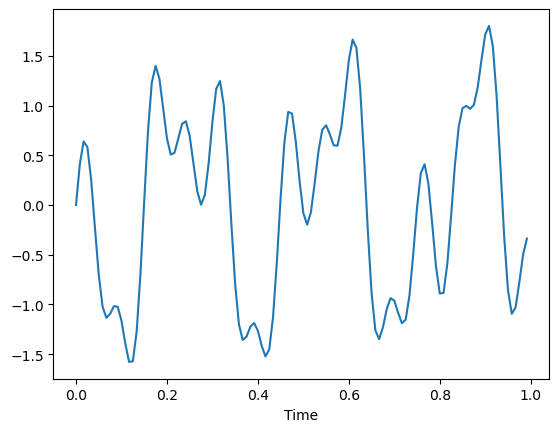

In [119]:
plt.plot(observations, target);
plt.xlabel("Time");

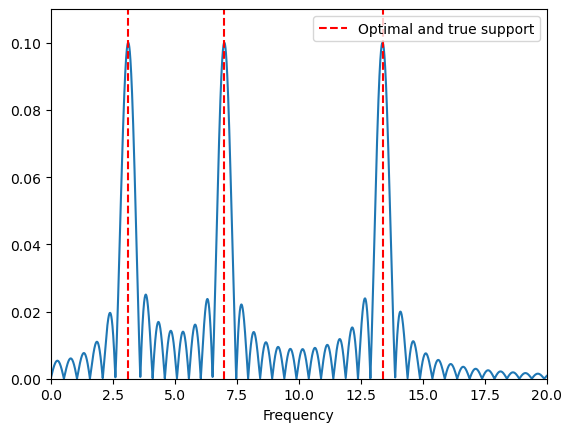

In [ ]:
u_tilde = u # Newton solution
a = np.arange(Omega[0][0],Omega[0][1],0.005)
vals = np.array([np.abs(p(u_tilde)(np.array([x]))) for x in a])
plt.plot(a,vals);
for i, pos in enumerate(u_tilde.support):
    if not i:
        plt.axvline(x=pos, linestyle="--", c="r", label="Optimal and true support");
    else:
        plt.axvline(x=pos, linestyle="--", c="r");
plt.xlabel("Frequency");
plt.ylim(0,0.11);
plt.xlim(0, 20);
plt.legend();

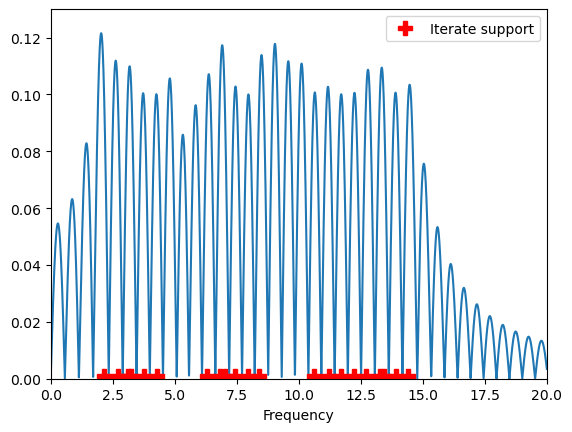

In [ ]:
u_tilde = u # LPDAP iterate after 30 ierations
a = np.arange(Omega[0][0],Omega[0][1],0.005)
vals = np.array([np.abs(p(u_tilde)(np.array([x]))) for x in a])
plt.plot(a,vals);
for i, pos in enumerate(u_tilde.support):
    if not i:
        plt.plot(pos,0.001, "P", c="r", label="Iterate support", markersize=10)
    else:
        plt.plot(pos,0.001, "P", c="r", markersize=10)
plt.xlabel("Frequency");
plt.ylim(0,0.13);
plt.xlim(0, 20);
plt.legend();

In [ ]:
residuals_pdap = np.array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388053e-02,
       1.50239777e-02, 8.58376260e-03, 6.60215209e-03, 6.26160461e-03,
       5.81056961e-03, 5.68714558e-03, 5.63453917e-03, 2.74798169e-03,
       2.49625308e-03, 2.43692856e-03, 1.09428956e-03, 1.06241338e-03,
       9.64583839e-04, 3.70010644e-04, 3.28227685e-04, 3.27716477e-04,
       1.08225414e-04, 8.89059425e-05, 8.85996721e-05, 2.08581002e-05,
       1.15859863e-05, 1.14112347e-05, 8.58446300e-06, 4.06824318e-06,
       3.96465275e-06, 2.55842175e-06, 1.39500443e-06, 1.33895722e-06,
       6.37730666e-07, 3.72191017e-07, 3.43278640e-07, 1.86417766e-07,
       1.07771234e-07, 9.30297483e-08, 4.47907718e-08, 3.13017950e-08,
       2.38730088e-08, 1.63320791e-08, 9.87057930e-09, 6.13811726e-09,
       2.36248926e-09, 2.29318572e-09, 4.22883784e-10, 3.32216477e-10,
       2.96567576e-10, 1.97008548e-10, 1.51335777e-10, 1.33198313e-10,
       8.31296143e-11, 6.02084493e-11, 5.10619047e-11, 2.59552657e-11,
       1.44735335e-11, 9.88081839e-12, 6.27009555e-12, 4.28232450e-12,
       3.35426131e-12, 1.54451452e-12, 6.06209527e-13, 2.64455124e-13])

times_pdap = np.array([2.38418579e-07, 1.44747734e-01, 2.80295134e-01, 4.21657801e-01,
       4.89504814e-01, 5.54171801e-01, 6.21161699e-01, 6.92107677e-01,
       7.67526627e-01, 8.35987091e-01, 9.23215628e-01, 9.91173506e-01,
       1.05550480e+00, 1.12198663e+00, 1.18742347e+00, 1.24858093e+00,
       1.31444311e+00, 1.38890338e+00, 1.46170950e+00, 1.53741741e+00,
       1.62911844e+00, 1.72034478e+00, 1.80127144e+00, 1.88783288e+00,
       1.95663786e+00, 2.02650619e+00, 2.09106112e+00, 2.15603662e+00,
       2.22199249e+00, 2.29011488e+00, 2.37570310e+00, 2.44392920e+00,
       2.51476240e+00, 2.58300400e+00, 2.65028501e+00, 2.72127962e+00,
       2.78932524e+00, 2.88072634e+00, 2.97178650e+00, 3.06618643e+00,
       3.15616083e+00, 3.24662495e+00, 3.31682277e+00, 3.38224006e+00,
       3.47225022e+00, 3.56463027e+00, 3.65584350e+00, 3.74674320e+00,
       3.83884501e+00, 3.93009400e+00, 4.02526259e+00, 4.11602402e+00,
       4.20772243e+00, 4.29821467e+00, 4.36960793e+00, 4.45754361e+00,
       4.54448533e+00, 4.62940335e+00, 4.69551659e+00, 4.76374626e+00,
       4.83393884e+00, 4.89966536e+00, 4.96472788e+00, 5.03161097e+00])

supports_pdap = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  9,  9,  8,  7,  7,  7,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6])

residuals_newton = np.array([ 5.26929402e+01,  5.26929402e+01,  2.22783817e+01,  2.22757012e+01,
        2.22757012e+01,  2.22757012e+01,  1.67294819e+01,  7.44717092e+00,
        7.44712096e+00,  7.44712096e+00,  7.13613228e+00,  1.71201655e-03,
        7.72957685e-08, -3.60822483e-15, -3.85802501e-15, -3.85802501e-15])

times_newton = np.array([2.38418579e-07, 1.03397369e-02, 3.25956345e-02, 5.25333881e-02,
       7.40909576e-02, 9.82441902e-02, 1.30960703e-01, 1.46838903e-01,
       1.58454418e-01, 1.71169758e-01, 1.86296225e-01, 1.96773529e-01,
       2.05665350e-01, 2.13721991e-01, 2.79594660e-01, 3.43407631e-01])

supports_newton = np.array([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3])

intervals_newton = np.array([[ 1.5,  5.5],
       [ 6.5,  9.5],
       [10.5, 15.5]])

epsilons_newton = np.array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 1.81577646e-09, 4.18656121e-15])

residuals_newton_damped = np.array([ 5.26929402e+01,  5.26929402e+01,  2.26483696e+01,  2.26483696e+01,
        7.53644619e+00,  7.53644619e+00,  2.75589320e-01,  2.29500092e-01,
        1.89679992e-01,  1.55458948e-01,  1.26228493e-01,  1.01433725e-01,
        8.05670039e-02,  6.31629604e-02,  4.87945453e-02,  3.70698755e-02,
        2.76297185e-02,  2.01454822e-02,  1.43176099e-02,  9.87429470e-03,
        6.57044975e-03,  4.18687522e-03,  2.52957369e-03,  1.42916864e-03,
        7.40382236e-04,  3.41524670e-04,  1.33936543e-04,  4.12988467e-05,
        8.66414503e-06,  9.16449898e-07,  2.42981779e-08,  3.01275116e-11,
       -3.80251386e-15, -3.83026943e-15, -3.83026943e-15])

times_newton_damped = np.array([2.38418579e-07, 1.01959705e-02, 2.44181156e-02, 4.55415249e-02,
       7.55374432e-02, 1.01310015e-01, 1.17352009e-01, 1.27764225e-01,
       1.43806458e-01, 1.54491901e-01, 1.63487196e-01, 1.75086737e-01,
       1.86660528e-01, 1.96220398e-01, 2.07118034e-01, 2.18739033e-01,
       2.30312586e-01, 2.41689920e-01, 2.51699448e-01, 2.61953831e-01,
       2.69539356e-01, 2.79683590e-01, 2.87734985e-01, 2.98524857e-01,
       3.06244850e-01, 3.16206217e-01, 3.23993683e-01, 3.34265471e-01,
       3.41686726e-01, 3.52069855e-01, 3.59730482e-01, 3.69768858e-01,
       4.33537483e-01, 4.41210270e-01, 5.06009102e-01])

supports_newton_damped = np.array([0, 0, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

intervals_newton_damped = np.array([[ 1.5,  2.5],
       [ 3.5,  4.5],
       [ 5.5, 34.5]])

epsilons_newton_damped = np.array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       4.14104276e-09, 4.14104276e-09, 5.61723242e-15])

residuals_lpdap = np.array([5.26929402e+01, 2.27036009e+01, 7.58425867e+00, 7.58339252e+00,
       3.65763628e-01, 2.08005076e-01, 1.73018496e-01, 4.60809595e-02,
       1.75681395e-02, 1.46086267e-02, 1.19478398e-02, 1.06827200e-02,
       9.83991899e-03, 9.30460448e-03, 9.20230503e-03, 9.08020647e-03,
       9.00130432e-03, 8.97509436e-03, 8.95127215e-03, 8.93178328e-03,
       8.92231995e-03, 8.91153929e-03, 8.90661772e-03, 8.90504254e-03,
       6.20975317e-03, 3.73269906e-03, 2.85028196e-03, 2.84743442e-03,
       2.84117523e-03, 1.74865652e-03, 1.74714985e-03, 9.49684073e-04,
       5.70649169e-04, 5.70587220e-04, 2.42390829e-04, 2.25786179e-04,
       2.25786179e-04, 1.93058537e-04, 6.72293647e-05, 5.38232997e-05,
       5.38232997e-05, 4.88657046e-05, 4.20376601e-05, 2.14170931e-05,
       1.54706491e-05, 1.54706491e-05, 1.51035455e-05, 1.17995318e-05,
       5.35359544e-06, 4.51032555e-06, 4.14828685e-06, 3.93497701e-06,
       2.30759458e-06, 1.69661099e-06, 1.52127902e-06, 1.52127902e-06,
       1.41329276e-06, 7.48565020e-07, 6.02495626e-07, 2.96967478e-07,
       2.52691396e-07, 2.11128902e-07, 1.75963442e-07, 7.98911172e-08,
       6.79515331e-08, 6.79208871e-08, 5.44293179e-08, 3.68561539e-08,
       2.60115424e-08, 2.60115424e-08, 2.60097425e-08, 1.71941612e-08,
       1.05450139e-08, 5.68852160e-09, 5.09200673e-09, 3.80388065e-09,
       2.66887662e-09, 2.62684180e-09, 2.55926674e-09, 1.21195132e-09,
       1.19179056e-09, 1.17725305e-09, 7.05446368e-10, 3.90002253e-10,
       3.49914708e-10, 3.49856505e-10, 3.31843664e-10, 1.79882165e-10,
       1.50701007e-10, 6.94563851e-11, 6.94302393e-11, 6.04668537e-11,
       4.68600714e-11, 2.66583144e-11, 2.23854268e-11, 1.96976879e-11,
       1.77524107e-11, 1.09784681e-11, 1.09742215e-11, 6.77455314e-12,
       6.13728512e-12, 5.66055536e-12, 3.28689853e-12, 2.54715693e-12,
       5.21249710e-13, 5.20861132e-13, 2.39863684e-13, 1.71945791e-13,
       1.59650071e-13])

times_lpdap = np.array([3.33929062e-03, 4.03299332e-02, 6.54413700e-02, 9.00952816e-02,
       1.17777109e-01, 1.46612883e-01, 1.74020290e-01, 1.94362879e-01,
       2.16018438e-01, 2.45656490e-01, 2.76825666e-01, 3.07981491e-01,
       3.36368561e-01, 3.67496014e-01, 3.93160105e-01, 4.14505720e-01,
       4.35403585e-01, 4.62241411e-01, 5.41819334e-01, 5.76987743e-01,
       6.05555534e-01, 6.96088314e-01, 7.26593018e-01, 8.37739944e-01,
       8.68129015e-01, 8.93475771e-01, 9.76476192e-01, 9.95888472e-01,
       1.02132773e+00, 1.04877758e+00, 1.06623602e+00, 1.13967371e+00,
       1.16146350e+00, 1.24819207e+00, 1.27119184e+00, 1.29541397e+00,
       1.31625557e+00, 1.33803129e+00, 1.43804455e+00, 1.45629191e+00,
       1.47178650e+00, 1.49361062e+00, 1.51457167e+00, 1.61387873e+00,
       1.63456464e+00, 1.65512395e+00, 1.67402387e+00, 1.69551730e+00,
       1.77603912e+00, 1.85229588e+00, 1.86963272e+00, 1.88879991e+00,
       1.91163778e+00, 2.00254798e+00, 2.02206516e+00, 2.03980160e+00,
       2.05728889e+00, 2.07406855e+00, 2.09057403e+00, 2.17694616e+00,
       2.19308543e+00, 2.21007419e+00, 2.22690392e+00, 2.30189371e+00,
       2.38954186e+00, 2.48826861e+00, 2.50957775e+00, 2.52556419e+00,
       2.60203052e+00, 2.67510939e+00, 2.77255845e+00, 2.79619527e+00,
       2.81560302e+00, 2.91905904e+00, 2.99341178e+00, 3.00818276e+00,
       3.02768445e+00, 3.04307127e+00, 3.05927587e+00, 3.16291046e+00,
       3.18222046e+00, 3.19866872e+00, 3.21726656e+00, 3.23404884e+00,
       3.35078168e+00, 3.44812870e+00, 3.47121191e+00, 3.49223018e+00,
       3.51275945e+00, 3.60015798e+00, 3.66954589e+00, 3.68557262e+00,
       3.70162892e+00, 3.71518302e+00, 3.81193614e+00, 3.82942843e+00,
       3.84676147e+00, 3.86699080e+00, 3.88441515e+00, 3.98476672e+00,
       4.00261164e+00, 4.02128744e+00, 4.03945827e+00, 4.05781460e+00,
       4.15015936e+00, 4.21856475e+00, 4.23385525e+00, 4.25235200e+00,
       4.35099697e+00])

supports_lpdap = np.array([ 0,  1,  2,  3,  4,  5,  5,  6,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 18, 15, 13, 13, 13, 11, 11,  9,  7,  7,
        7,  8,  8,  6,  6,  7,  7,  6,  6,  6,  7,  7,  6,  6,  7,  6,  7,
        6,  6,  6,  7,  7,  6,  7,  6,  6,  7,  6,  6,  7,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  6,  7,  7,  6,  6,  6,  7,  6,  6,  7,  6,
        6,  6,  7,  6,  6,  6,  6,  6,  7,  6,  7,  6,  6,  6,  6,  7,  6,
        7,  6,  6,  6,  6,  6,  6])

epsilons_lpdap = np.array([5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 2.33970495e-02,
       2.33970495e-02, 2.33970495e-02, 1.09934084e-02, 1.09934084e-02,
       4.87329698e-03, 4.87329698e-03, 4.87329698e-03, 2.08756260e-03,
       2.08756260e-03, 2.08756260e-03, 2.08756260e-03, 2.08756260e-03,
       8.15198504e-04, 8.15198504e-04, 2.26700561e-04, 2.26700561e-04,
       2.26700561e-04, 2.26700561e-04, 2.26700561e-04, 3.30218973e-05,
       3.30218973e-05, 3.30218973e-05, 3.30218973e-05, 3.30218973e-05,
       7.65566882e-06, 7.65566882e-06, 7.65566882e-06, 7.65566882e-06,
       7.65566882e-06, 7.65566882e-06, 1.84052199e-06, 1.84052199e-06,
       1.84052199e-06, 1.84052199e-06, 4.58428877e-07, 4.58428877e-07,
       4.58428877e-07, 4.58428877e-07, 4.58428877e-07, 4.58428877e-07,
       1.14021824e-07, 1.14021824e-07, 1.14021824e-07, 1.14021824e-07,
       1.14021824e-07, 1.14021824e-07, 2.66481147e-08, 2.66481147e-08,
       2.66481147e-08, 2.66481147e-08, 2.66481147e-08, 6.87244673e-09,
       6.87244673e-09, 6.87244673e-09, 6.87244673e-09, 1.62702117e-09,
       1.62702117e-09, 1.62702117e-09, 1.62702117e-09, 1.62702117e-09,
       4.18839455e-10, 4.18839455e-10, 4.18839455e-10, 4.18839455e-10,
       4.18839455e-10, 4.18839455e-10, 1.08810500e-10, 1.08810500e-10,
       1.08810500e-10, 1.08810500e-10, 1.08810500e-10, 2.67817447e-11,
       2.67817447e-11, 2.67817447e-11, 2.67817447e-11, 6.60848816e-12,
       6.60848816e-12, 6.60848816e-12, 6.60848816e-12, 6.60848816e-12,
       1.68762757e-12, 1.68762757e-12, 1.68762757e-12, 1.68762757e-12,
       1.68762757e-12, 1.68762757e-12, 3.96318815e-13, 3.96318815e-13,
       3.96318815e-13])

In [ ]:
names = ["PDAP", "LPDAP", "NLGCG", "NLGCG (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.ylim(1e-12, 55);
plt.legend();
plt.show()

In [ ]:
names = ["LPDAP", "NLGCG", "NLGCG (damped)"]
styles = ["--", "-.", ":"]
colors = ["orange", "green", "red"]
plt.figure(figsize=(11.25,5))
for array, name, style, color in zip([epsilons_lpdap, epsilons_newton, epsilons_newton_damped], names, styles, colors):
    plt.semilogy(np.array(range(len(array))),array, style, label=name, color=color);
plt.ylabel("Lazy threshold");
plt.xlabel("Total iterations");
plt.ylim(1e-12, 0.1);
# plt.xlim(0, 135);
plt.legend();
plt.show()

In [ ]:
names = ["PDAP", "LPDAP", "NLGCG", "NLGCG (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([supports_pdap, supports_lpdap, supports_newton, supports_newton_damped], names, styles):
    plt.plot(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Support size");
plt.xlabel("Total iterations");
plt.legend();
plt.show()

In [ ]:
names = ["PDAP", "LPDAP", "NLGCG", "NLGCG (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for domain, array, name, style in zip([times_pdap, times_lpdap, times_newton, times_newton_damped], [residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(domain, array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Time (s)");
plt.ylim(1e-12, 55);
plt.legend();
plt.show()

In [ ]:
plt.figure(figsize=(11.25,5))
plt.semilogy(np.array(range(len(residuals_newton))), residuals_newton, linestyle="-.", color="green");
for interval in intervals_newton:
    plt.fill_between(interval, 0, 130, hatch="/", color="gray", alpha=0.2);
plt.ylim(1e-14, 55);
plt.xlim(0, 13);
plt.xlabel("Total iterations");
plt.show()